# Transform external data to chombo_HDF5

In [75]:
import h5py as h5
# import yt
import numpy as np
import os

"""
SET PARAMETERS
"""
path = "/home/cjoana/GRChombo_outfiles/CHECKPOINT_HDF5_IO/"
filename = path +"checkpoint_template.hdf5"  # Name of the new file to create

N = 100
L = 128000
K_const = -3.14 # 4.68e-7
dt_multiplier = 0.1

def transform_PhiToChi(x): return np.exp(-2*x)

# Set components
component_names = [  # The order is important: component_0 ... component_(nth-1)
    "chi",
    
    "h11",    "h12",    "h13",    "h22", "h23", "h33",

    "K",

    "A11",    "A12",    "A13",    "A22", "A23", "A33",

    "Theta",

    "Gamma1", "Gamma2", "Gamma3",

    "lapse",

    "shift1", "shift2", "shift3",

    "B1",     "B2",     "B3",

    "phi",    "Pi",

    "Ham",    "Mom1",   "Mom2",   "Mom3"   
]

temp_comp = np.zeros((N, N, N))   # template for components: array [Nx, Ny. Nz]
dset = dict()
# Here set the value of the components (default: to zero)

dset['chi'] = temp_comp.copy()
dset['phi'] = temp_comp.copy()
dset['K'] = temp_comp.copy() + K_const
dset['Ham'] = temp_comp.copy()
dset['h11'] = temp_comp.copy() + 1.
dset['h22'] = temp_comp.copy() + 1.
dset['h33'] = temp_comp.copy() + 1.
dset['lapse'] = temp_comp.copy() + 1.


## Constructing variables
# # Reading from file
# sfdata = np.loadtxt(path + 'gridofsf000.dat')
# logconfdata = np.loadtxt(path + 'gridofphi000.dat')
indices = []
for z in range(N):
    for y in range(N):
        for x in range(N):
            ind = x + y*N + z*N**2 
            dset['phi'][x][y][z] = 0.33 * (np.sin(x * N/L) + np.sin(y * N/L) + np.sin(z * N/L))
            # dset['phi'][x][y][z] = sfdata[ind]
            dset['chi'][x][y][z] = 1. 
            #dset['chi'][x][y][z] = transform_PhiToChi(logconfdata[ind]) 
            indices.append(ind)

print("checks")
print("K mean:",  np.mean(dset['K']))
print("phi mean:",  np.mean(dset['phi']))


checks
K mean: -3.1399999999999912
phi mean: 0.03826588202323128


In [76]:
if not os.path.exists(path):
    os.mkdir(path)
    print(" ! > new mkdir: ", path)

"""
Mesh and Other Params
"""
# def base attributes
base_attrb = dict()
base_attrb['time'] = 0.0
base_attrb['iteration'] = 0
base_attrb['max_level'] = 0
base_attrb['num_components'] = len(component_names)
base_attrb['num_levels'] = 1
base_attrb['regrid_interval_0'] = 1
base_attrb['steps_since_regrid_0'] = 0
for comp,  name in enumerate(component_names):
    key = 'component_' + str(comp)
    tt = 'S' + str(len(name))
    base_attrb[key] = np.array(name, dtype=tt)


# def Chombo_global attributes
chombogloba_attrb = dict()
chombogloba_attrb['testReal'] = 0.0
chombogloba_attrb['SpaceDim'] = 3

# def level0 attributes
level_attrb = dict()
level_attrb['dt'] = float(L)/N * dt_multiplier
level_attrb['dx'] = float(L)/N
level_attrb['time'] = 0.0
level_attrb['is_periodic_0'] = 1
level_attrb['is_periodic_1'] = 1
level_attrb['is_periodic_2'] = 1
level_attrb['ref_ratio']= 2
level_attrb['tag_buffer_size'] = 3
prob_dom = (0, 0, 0, N-1, N-1, N-1)
prob_dt = np.dtype([('lo_i', '<i4'), ('lo_j', '<i4'), ('lo_k', '<i4'),
                    ('hi_i', '<i4'), ('hi_j', '<i4'), ('hi_k', '<i4')])
level_attrb['prob_domain'] = np.array(prob_dom, dtype=prob_dt)
boxes = np.array([(0, 0, 0, N-1, N-1, N-1)],
      dtype=[('lo_i', '<i4'), ('lo_j', '<i4'), ('lo_k', '<i4'), ('hi_i', '<i4'), ('hi_j', '<i4'), ('hi_k', '<i4')])


""""
CREATE HDF5
"""

#TODO: if overwrite:   [...] else: raise()
if os.path.exists(filename):
    os.remove(filename)

h5file = h5.File(filename, 'w')  # New hdf5 file I want to create

# base attributes
for key in base_attrb.keys():
    h5file.attrs[key] = base_attrb[key]

# group: Chombo_global
chg = h5file.create_group('Chombo_global')
for key in chombogloba_attrb.keys():
    chg.attrs[key] = chombogloba_attrb[key]

# group: levels
l0 = h5file.create_group('level_0')
for key in level_attrb.keys():
    l0.attrs[key] = level_attrb[key]
sl0 = l0.create_group('data_attributes')
dadt = np.dtype([('intvecti', '<i4'), ('intvectj', '<i4'), ('intvectk', '<i4')])
sl0.attrs['ghost'] = np.array((3, 3, 3),  dtype=dadt)
sl0.attrs['outputGhost'] = np.array( (0, 0, 0),  dtype=dadt)
sl0.attrs['comps'] = base_attrb['num_components']
sl0.attrs['objectType'] = np.array('FArrayBox', dtype='S10')

# level datasets
dataset = np.zeros((base_attrb['num_components'], N, N, N))
for i, comp in enumerate(component_names):
    if comp in dset.keys():
        dataset[i] = dset[comp].T
fdset = []
for c in range(base_attrb['num_components']):
    fc = dataset[c].T.flatten()
    fdset.extend(fc)
fdset = np.array(fdset)

l0.create_dataset("Processors", data=np.array([0]))
l0.create_dataset("boxes",  data=boxes)
l0.create_dataset("data:offsets=0",  data=np.array([0, (base_attrb['num_components'])*N**3]))
l0.create_dataset("data:datatype=0",  data=fdset)

h5file.close()

# Loading routine

In [1]:
h5file = h5.File(filename,'r')

attrs_base = np.array(h5file.attrs)
sim_time = h5file.attrs['time']
# max_level = h5file.attrs['max_level']
num_level = h5file.attrs['num_levels']

fields = np.array([h5file.attrs['component_' + str(i)] for i in range(h5file.attrs['num_components'])],
                 dtype=str)
num_field = len(fields)
att_dic = dict(h5file.attrs)


print(attrs_base
     ,
     h5file.attrs['num_levels']
      ,
      fields,
     )

dlen = lv0['data:offsets=0'][1]

def field_idx(n):
    return [dlen//num_field *(n), dlen//num_field *(n+1)]

# lv0 =h5file["level_0"]
# print( list(lv0.keys())
#      ,
#      fields[25]
#       ,
#      field_idx(25)
#      )

# # #1015808
sfpos = field_idx(25)

# cs = np.arange(sfpos[0], sfpos[1]).tolist()
# cc = sfpos

dt = lv0['data:datatype=0'][sfpos[0]:sfpos[1]]    
# dt = lv0['data:datatype=0'][cs]    ## this is SLOW  (60x  more than above)


print(len(dt))

# print(
#     np.mean(dt), 
#     np.std(dt)
#      )


NameError: name 'h5' is not defined

# Comparison (plotting)

In [71]:
import yt

# Uncomment to enable warnings, 
yt.funcs.mylog.setLevel(50)     # or 1: full-log  and 50: no-log

# load the packages required
import matplotlib.pyplot as plt;
import numpy as np
import time
from matplotlib import pylab
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from yt import derived_field
import matplotlib.gridspec as gridspec

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
np.random.seed(777777)

# path = "/home/cjoana/Desktop/GRChombo_outfiles/LargeScalarField_smallgauss/"
path = "/home/cjoana/GRChombo_outfiles/Comparison_HDF5/"

path1 = path + "Comparison_GRCHOMBO_v2.3d.hdf5"
path2 = path + "Comparison_ICARUS_v2.3d.hdf5"
path3 = path + "Comparison_GRCHOMBO_v1.3d.hdf5"

# path2 = "/home/cjoana/mnt01/Higgs_inflation/GaussEvo_IClv2_Runlv2/Large_ScalarFieldp_{0}.3d.hdf5"
# path1 = "/home/cjoana/mnt01/Higgs_inflation/GaussEvo_IClv1_Runlv2/vcPoissonOut.3d_19_Lv0N256.hdf5"
# path2 = "/home/cjoana/mnt01/Higgs_inflation/GaussEvo_IClv1_Runlv2/vcPoissonOut.3d_19_Lv2N32.hdf5"


def filename(x, path=path):
    return path.format(str(x).zfill(6))

# fn = "/home/cjoana/Desktop/GRChombo_outfiles/SFHG_large/Large_ScalarField_000080.3d.hdf5"

def HG(phi):
    Mp = 1.0/np.sqrt(8.0*np.pi)
    mass = 2.5 * 1e-12
    V = mass * (Mp ** 4.0) *  (1.0 - np.exp(-np.sqrt(2.0/3.0) * np.abs(phi)/Mp) ) **2.0   
    return V


def load_dataset(fn):
    # add field stored in memory 
    def _V(field, data):
        sf = np.real(data["phi"])
        Mp = 1.0/np.sqrt(8.0*np.pi)
        mass = 0.25 * 1e-11
        V = mass * (Mp ** 4.0) *  (1.0 - np.exp(-np.sqrt(2.0/3.0) * np.abs(sf)/Mp) ) **2.0   
        return V

    def _rho(field, data):    
        try:
            rho = -np.array(data["Ham_rho"])/(16*np.pi)
        except Exception as e:         
            rho = 0.5 * np.array(data["phi_gradient_magnitude"])**2 + \
                  0.5 * np.array(data["Pi"])**2 +  np.array(data["potential"])
        return rho
    
    def _rho_ratio(field, data):    
        try:
            rho = -np.array(data["Ham_rho"])/(16*np.pi)
        except Exception as e:         
            rho = 0.5 * np.array(data["phi_gradient_magnitude"])**2 + \
                  0.5 * np.array(data["Pi"])**2 +  np.array(data["potential"])
        
        return rho/np.array(data["potential"])
    
    def _gradient_phi_magnitude(field,data):
        return np.array(data["phi_gradient_magnitude"])

    ds = yt.frontends.chombo.ChomboDataset(fn)   

    ds.add_gradient_fields(   ("chombo", "chi")  )
    ds.add_gradient_fields(   ("chombo", "K")  )
    ds.add_gradient_fields(   ("chombo", "phi")  )
    ds.add_gradient_fields(   ("chombo", "Pi")  ) 

    ds.add_field(('chombo','potential'), function=_V, units="", take_log=False, display_name='potential')
    ds.add_field(('chombo','rho'), function=_rho, units="", take_log=False, display_name='rho')
    ds.add_field(('chombo','rho_ratio'), function=_rho_ratio, units="", take_log=False, display_name='rho_ratio')
    ds.add_field(('chombo','phi_gradient'), function=_gradient_phi_magnitude, units="", take_log=False, display_name='_gradient_phi_magnitude')

    return ds


def get_slice(field, ds, axis=2, cord=32, lim=(0, 63, 0, 63), res=(64, 64)):
    sl = ds.slice(axis, cord)
    frb = yt.FixedResolutionBuffer(sl, lim, res)
    arr = frb[field]
    return arr

def get_mean(field, ds):
    dd = ds.all_data()
    arr = np.mean(dd[field])
    return arr


def get_evo(field, path2, interval, set = "chombo"):
    values = []
    for t in interval: 
        fn = filename(t, path2)
        ds = load_dataset(fn)
        v = get_mean(field,ds)
        values.append(v)
    return np.array(values)


def get_allevo(path, interval, fields= ['phi', 'Pi', 'K', 'chi', 'Ham', 
                                        'Ham_trA2', 'Ham_rho', 'rho', 'rho_ratio'
#                                        ,'h11', 'h22', 'h33', 'h12', 'h13', 'h23'
                                       ]):
    mean_values = []
    std_values = []
    for t in interval: 
        fn = filename(t, path)
        print("\r loading ...{}".format(fn[-35:-5]), end=' ' )
        ds = load_dataset(fn)
        dd = ds.all_data()
        for field in fields:
            v = np.mean(dd[field])
            s = np.std(dd[field])
            mean_values.append(v)
            std_values.append(s)
    
    m_out = dict()
    s_out = dict()
    for i, field in enumerate(fields):
        m_out[field] = mean_values[i::len(fields)]
        s_out[field] = std_values[i::len(fields)]
        
    return m_out, s_out


/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'


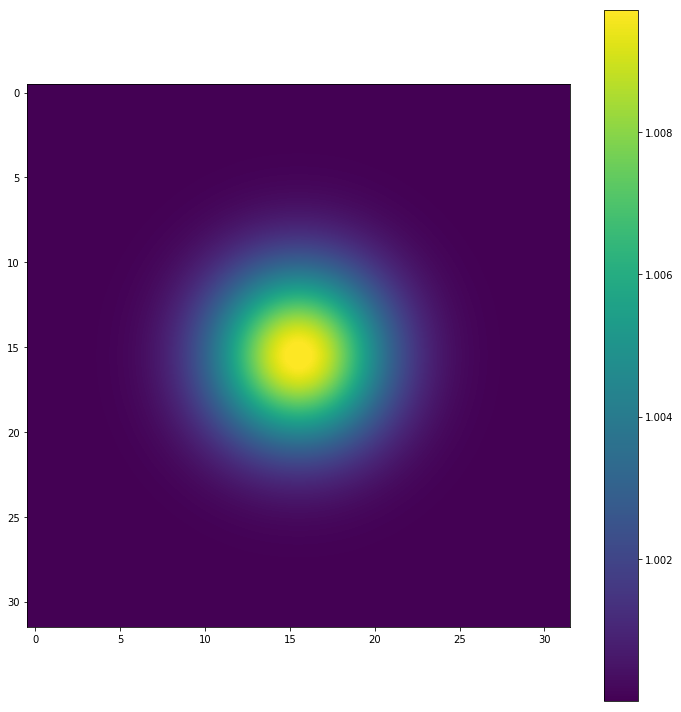

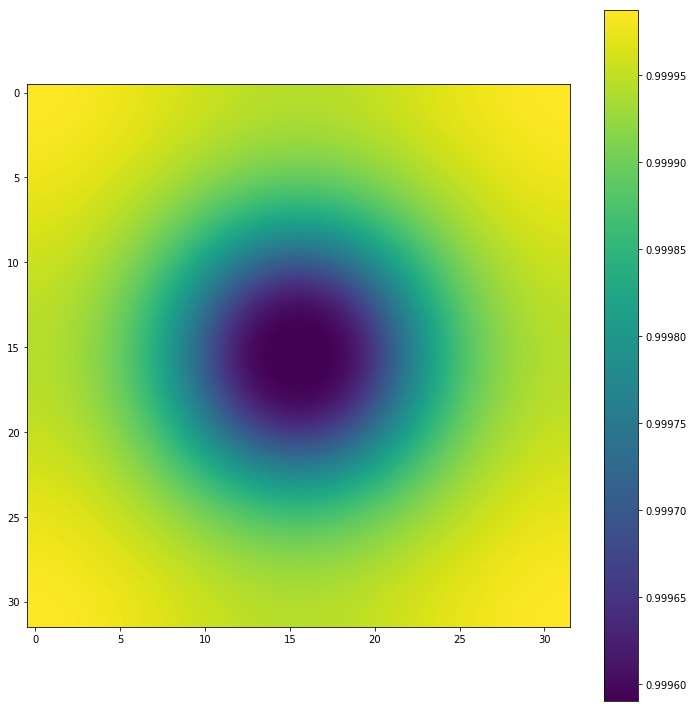

mean phi 1.0002201027117859 dimensionless
mean K -7.037356897109168e-07 dimensionless
mean chi 0.999941194269746 dimensionless


In [72]:
%matplotlib inline

def get_slice(field, ds, axis=2, cord=L/2, lim=(0, L, 0, L), res=(32, 32)):
    sl = ds.slice(axis, cord)
    frb = yt.FixedResolutionBuffer(sl, lim, res)
    arr = frb[field]
    return arr

ds = load_dataset(path1)

par_phi = par_sf = get_slice("phi", ds, res=(32,32))   # FSR it doesn't load "phi_gradient_magnitude"
par_chi = get_slice("chi", ds, res=(32,32))


fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
plot1 = ax.imshow( par_phi, interpolation='spline16' ) #'nearest')
fig.colorbar(plot1, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
plot2 = ax.imshow( np.array(par_chi, dtype=float) , interpolation='spline16' ) #'nearest')
fig.colorbar(plot2, ax=ax)
plt.show()


print('mean phi', np.mean(ds.all_data()['phi']) )
print('mean K', np.mean(ds.all_data()['K']) )
print('mean chi', np.mean(ds.all_data()['chi']) )

/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'


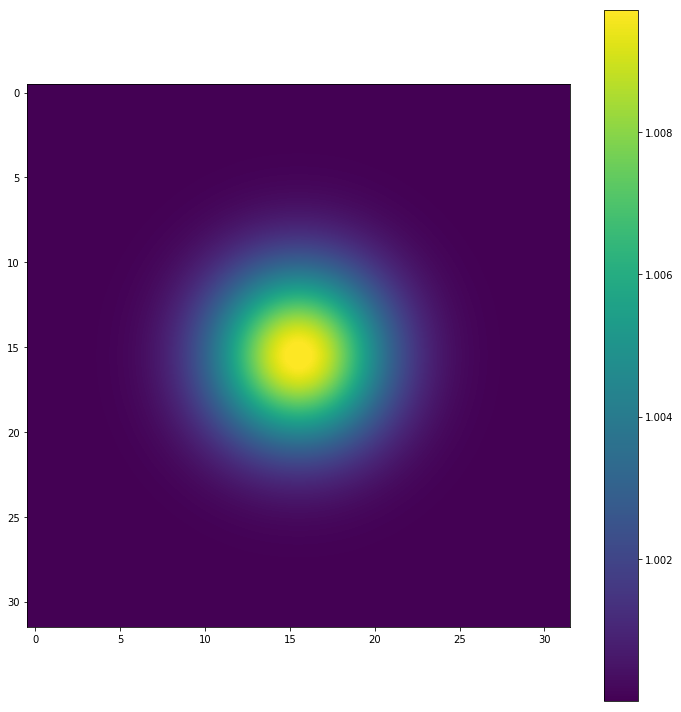

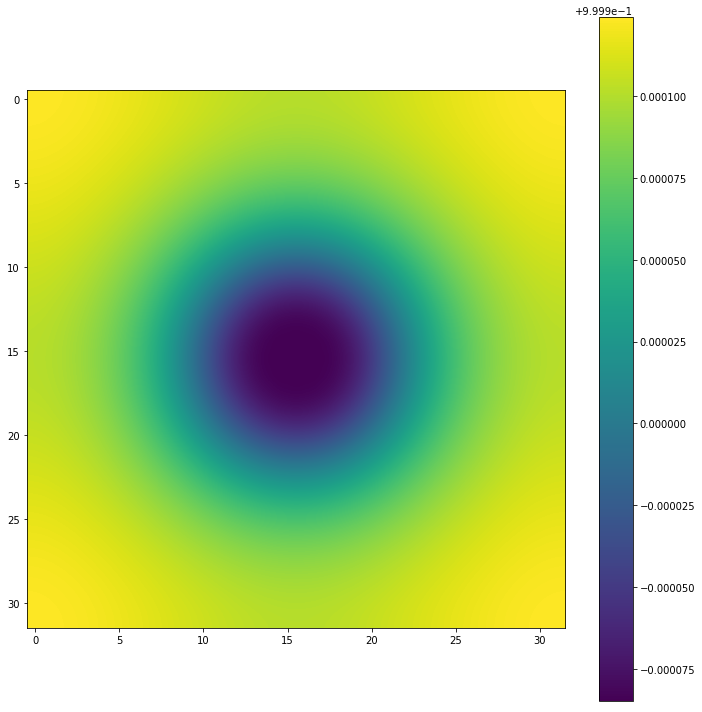

mean phi 1.0002201027117859 dimensionless
mean K 4.679999999999998e-07 dimensionless
mean chi 0.9999999282524208 dimensionless


In [73]:
def get_slice(field, ds, axis=2, cord=L/2, lim=(0, L, 0, L), res=(32, 32)):
    sl = ds.slice(axis, cord)
    frb = yt.FixedResolutionBuffer(sl, lim, res)
    arr = frb[field]
    return arr

ds = load_dataset(path2)

par_phi_IC = get_slice("phi", ds, res=(32,32))   # FSR it doesn't load "phi_gradient_magnitude"
par_chi_IC = get_slice("chi", ds, res=(32,32))


fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
plot1 = ax.imshow( par_phi_IC, interpolation='spline16' ) #'nearest')
fig.colorbar(plot1, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
plot2 = ax.imshow( np.array(par_chi_IC, dtype=float) , interpolation='spline16' ) #'nearest')
fig.colorbar(plot2, ax=ax)
plt.show()


print('mean phi', np.mean(ds.all_data()['phi']) )
print('mean K', np.mean(ds.all_data()['K']) )
print('mean chi', np.mean(ds.all_data()['chi']) )

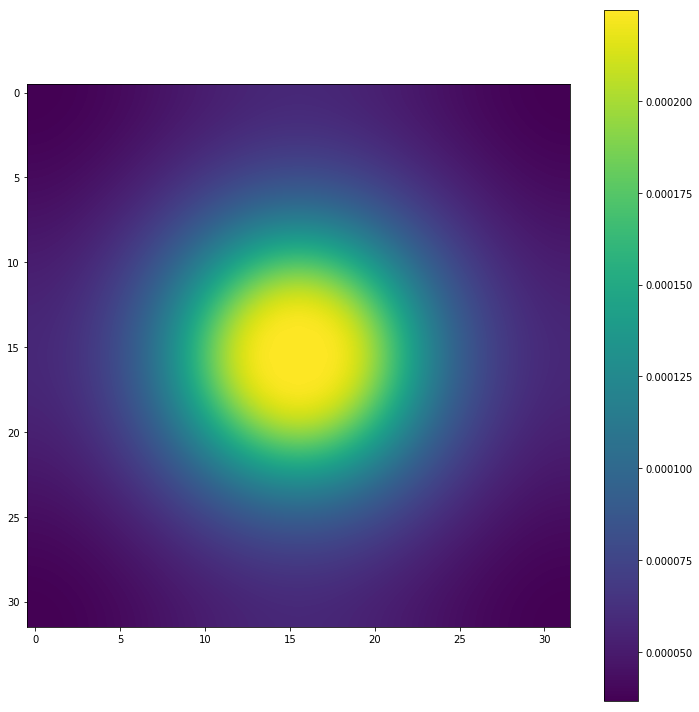

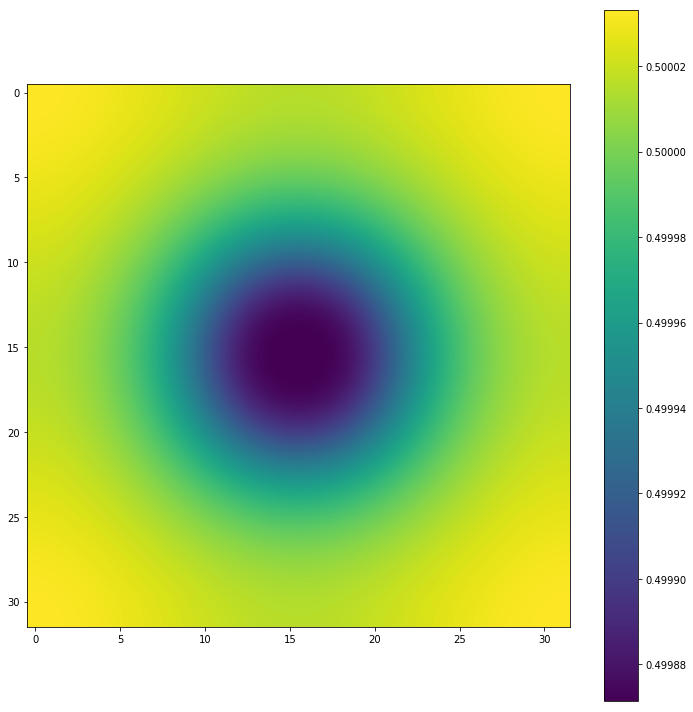

In [74]:
diff = par_chi_IC - par_chi 
ndiff = par_chi_IC - par_chi / (par_chi_IC + par_chi )


fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
plot1 = ax.imshow( diff, interpolation='spline16' ) #'nearest')
fig.colorbar(plot1, ax=ax)
plt.show()




fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
plot1 = ax.imshow( ndiff, interpolation='spline16' ) #'nearest')
fig.colorbar(plot1, ax=ax)
plt.show()

/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'


<IPython.core.display.Javascript object>


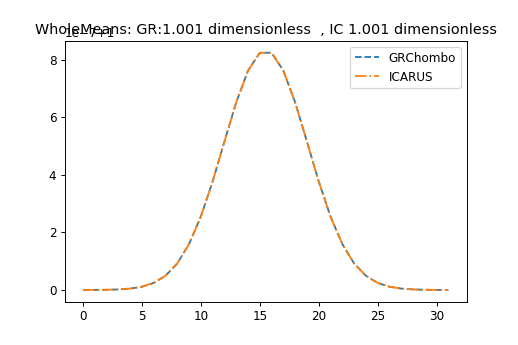

<IPython.core.display.Javascript object>


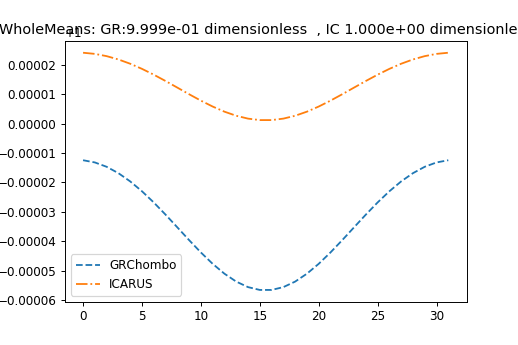

In [76]:
%matplotlib notebook

cI = L
cG = L

rI=32
rG=32
ds = load_dataset(path1)
par_phi = par_sf = get_slice("phi", ds,axis=2, cord=cG/2, lim=(0, L-1, 0, L-1), res=(rG, rG))   
par_chi = get_slice("chi", ds,        axis=2, cord=cG/2, lim=(0, L-1, 0, L-1), res=(rG, rG))


ds = load_dataset(path2)
par_phi_IC = par_sf_IC = get_slice("phi", ds,axis=2, cord=cI/2, lim=(1, L, 1, L), res=(rI, rI))   
par_chi_IC = get_slice("chi", ds,            axis=2, cord=cI/2, lim=(1, L, 1, L), res=(rI, rI))


cord = 31


# from scipy.interpolate import interp1d
# x = np.linspace(0, 31, num=32, endpoint=True)
# f = interp1d(x, v1)
# v1int = f(np.linspace(0, 31, num=64, endpoint=True))

v1 = par_phi[cord, ::]
v2 = par_phi_IC[cord, ::]

# x1 = np.arange(-0.5, 31.5 ,1)

title = "WholeMeans: GR:{0:.3f}  , IC {1:.3f}".format(np.mean(par_phi), np.mean(par_phi_IC))

# plt.plot(v1)
plt.plot(v1, '--' , label="GRChombo")
plt.plot(v2, '-.', label="ICARUS")
plt.title(title)
# plt.ylim(1.007,1.01)
# plt.xlim(14,17)
plt.legend()
plt.show()



fig = plt.figure()

v1 = par_chi[cord, ::]
v2 = par_chi_IC[cord, ::]

# x1 = np.arange(-0.5, 31.5 ,1)

title = "WholeMeans: GR:{0:.3e}  , IC {1:.3e}".format(np.mean(par_chi), np.mean(par_chi_IC))

# plt.plot(v1)
plt.plot(v1, '--' , label="GRChombo")
plt.plot(v2, '-.', label="ICARUS")
plt.title(title)
# plt.ylim(1.007,1.01)
# plt.xlim(14,17)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


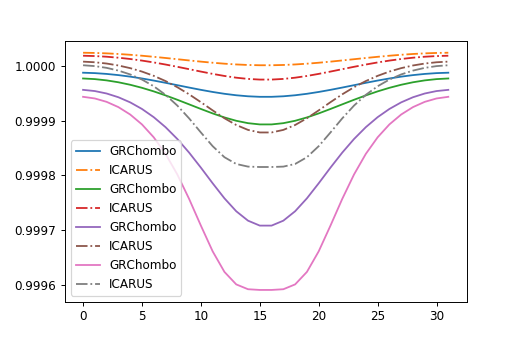

/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'


In [84]:
fig = plt.figure()

ds1 = load_dataset(path1)
ds2 = load_dataset(path2)
ds3 = load_dataset(path3)

gcord = L//2 -1
for ccord in [0,5,10,15]:
    title = str(cord)+"-Means: GR:{0:.3f}  , IC {1:.3f}".format(np.mean(par_chi[cord]), np.mean(par_chi_IC[cord]))
#     fig = plt.figure()
    # plt.plot(v1)
    v1 = get_slice("chi", ds1,  axis=2, cord=gcord, res=(32,32))[ccord]
    v2 = get_slice("chi", ds2,  axis=2, cord=gcord, res=(32,32))[ccord]
    v3 = get_slice("chi", ds3,  axis=2, cord=gcord, res=(32,32))[ccord]
    plt.plot(v1, '-' , label="GRChombo")
    plt.plot(v2, '-.', label="ICARUS")
#     plt.plot(v3, '-' , label="GRChombo_v1")
#     plt.title(title)
    # plt.ylim(1.007,1.01)
    # plt.xlim(14,17)
    plt.legend()
plt.show()

/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/cjoana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'


<IPython.core.display.Javascript object>


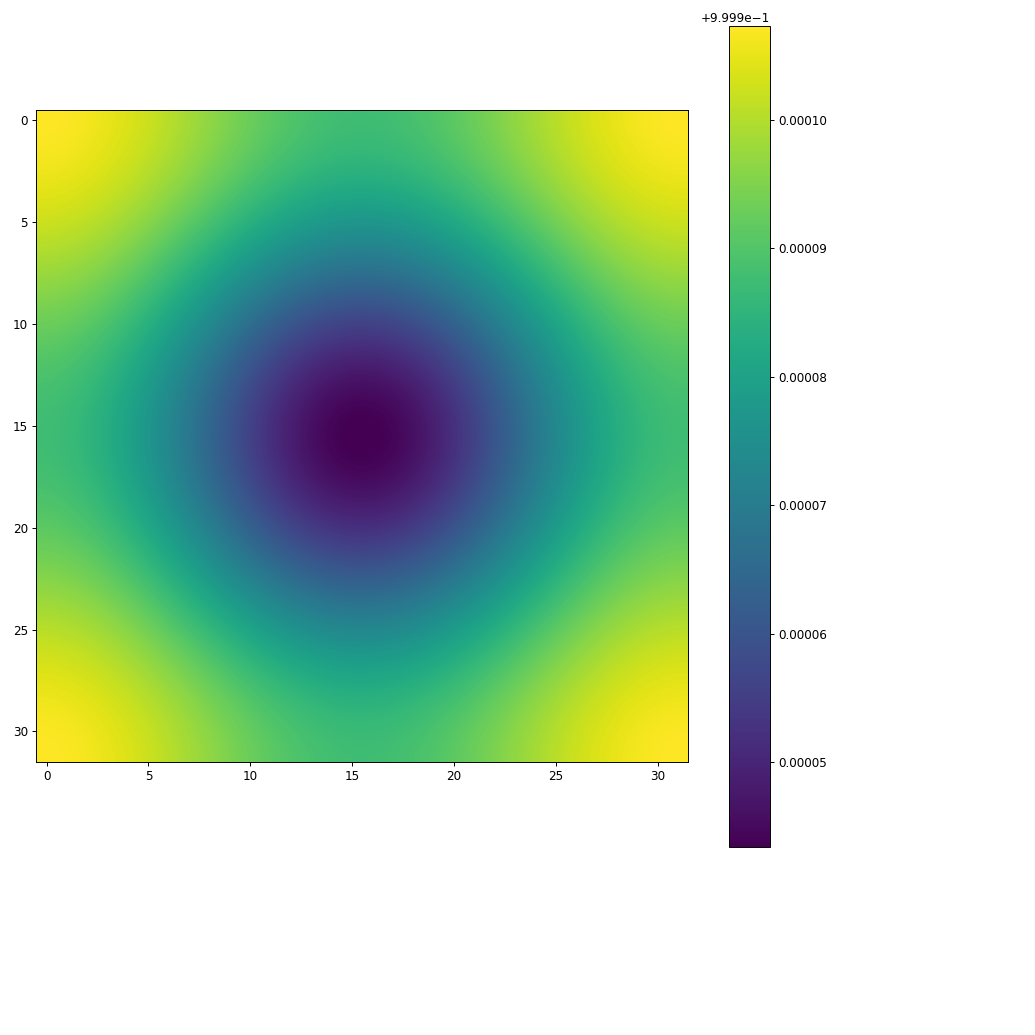

<IPython.core.display.Javascript object>


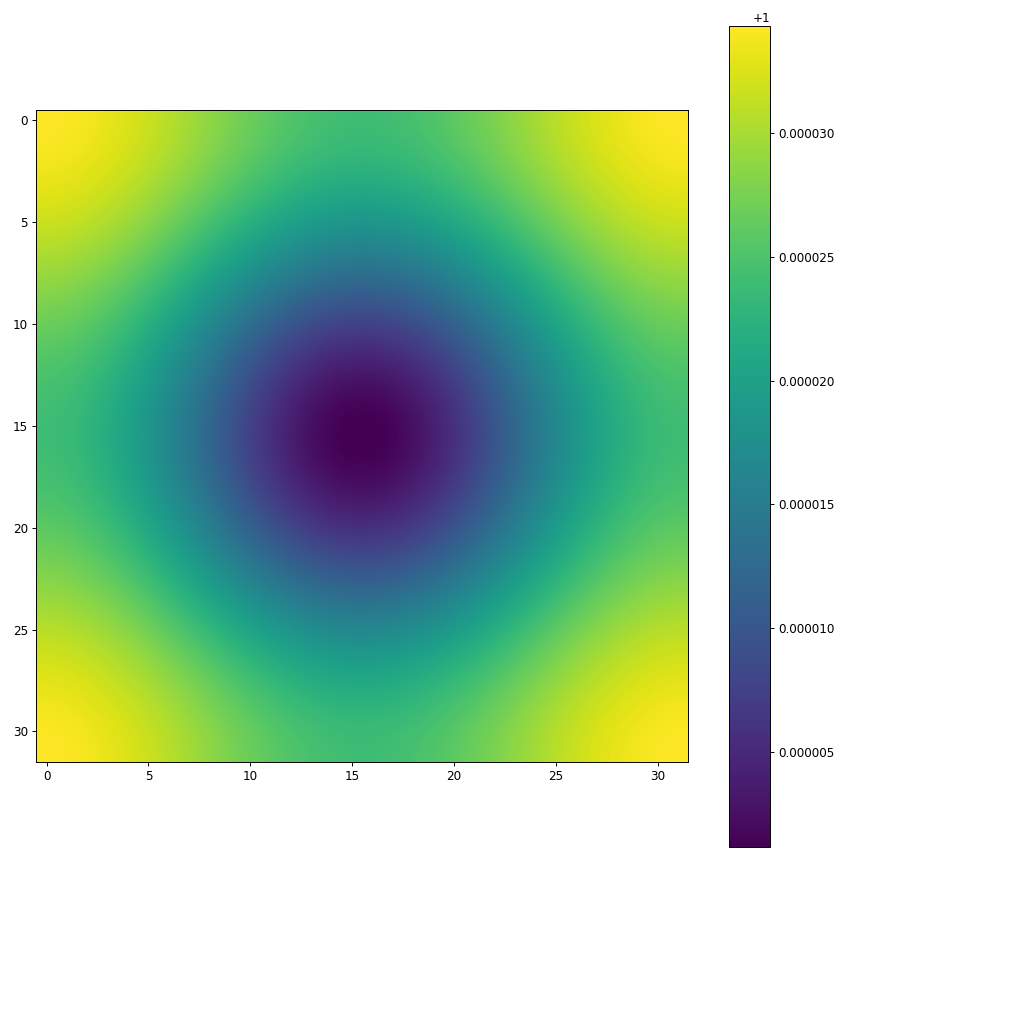

In [36]:
ds1 = load_dataset(path1)
ds2 = load_dataset(path2)

par_chi_GR = get_slice("chi", ds1,  axis=2, cord=0, res=(32,32))   
par_chi_IC = get_slice("chi", ds2,  axis=2, cord=0, res=(32,32))

fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
plot1 = ax.imshow( par_chi_GR, interpolation='spline16' ) #'nearest')
fig.colorbar(plot1, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
plot2 = ax.imshow( np.array(par_chi_IC, dtype=float) , interpolation='spline16' ) #'nearest')
fig.colorbar(plot2, ax=ax)
plt.show()

In [ ]:
# import numpy as np
# from scipy.interpolate import interpn

# # Vi = interpn((x,y,z), V, np.array([xi,yi,zi]).T)

# ds = load_dataset(path2)
# dd = ds.all_data()

# x = y = z = np.linspace(0, 31, num=N, endpoint=True)
# xi = yi = zi = np.linspace(0, 31, num=2*N, endpoint=True)

# V = dd['phi'].reshape([N,N,N])
# # Vi = interpn( (x,y,z), V , np.array([xi,yi,zi]).T)




# from scipy.interpolate import griddata


# Vi = griddata((x,y,z), V, np.array([xi,yi,zi]).T)


# plt.plot(Vi[:,0,0])
# print( Vi.shape )

## K value

In [ ]:
import numpy as np

gr, ic = [np.mean(par_phi), np.mean(par_phi_IC)]

def HG(phi):
    Mp = 1.0/np.sqrt(8.0*np.pi)
    mass = 2.5 * 1e-12
    mass = 1e-11
    V = mass * (Mp ** 4.0) *  (1.0 - np.exp(-np.sqrt(2.0/3.0) * np.abs(phi)/Mp) ) **2.0   
    return V

K_val = -np.sqrt( 24*np.pi* HG(  ic  )  )

print("K", K_val)
